In [1]:
from fipy import CellVariable, FaceVariable, Grid1D, ExplicitUpwindConvectionTerm, TransientTerm
from fipy import VanLeerConvectionTerm, UpwindConvectionTerm, ImplicitDiffusionTerm

import matplotlib.pyplot as plt
import numpy as np

In [2]:
dx = 2e-2
dt = 2e-3
D_L1 = 1.0 # Longitudinal dispersion coeffcient (mm2/s)
D_L2 = 2.0 
u = 50.0 # Fluid velocity (mm/s)
x0 = 0.7
t0 = 1e-2
t_end = 3e-2
dt = 3.0e-4
print(CFL := u*dt/dx)


mesh = Grid1D(dx=dx, nx=200)
x = mesh.cellCenters.numericValue[0]

0.75


In [3]:
C1 = CellVariable(mesh, 'solute1', hasOld=True)
C2 = CellVariable(mesh, 'solute2', hasOld=True)

In [4]:
# Instead of using ExplicitDiffusionTerm in the coupled equations, we can only use .faceGrad.divergence
# to represent such explicit diffusion terms
def adv_diff_eq(c, u, D):
    return TransientTerm(var=c) + VanLeerConvectionTerm(coeff=(u,), var=c) \
           - 0.5*(D*c.faceGrad).divergence - 0.5*ImplicitDiffusionTerm(coeff=D, var=c)

def gaussian(x, x0, t, u, D):
    return np.exp(-(x-x0-u*t)**2/(4.0*D*t)) / (4*np.pi*D*t)**0.5

In [5]:
t = t0
eq1 = adv_diff_eq(C1, u, D_L1) 
eq2 = adv_diff_eq(C2, u, D_L2)
eq = eq1 & eq2

# Initial_condition
C1.numericValue[:] = gaussian(x, x0, t0, u, D_L1)
C2.numericValue[:] = gaussian(x, x0, t0, u, D_L2)

while t < t_end:
    C1.updateOld()
    C2.updateOld()
    eq.solve(dt=dt)
    t += dt

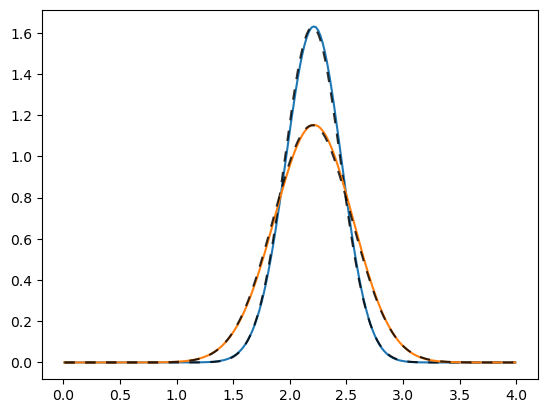

In [6]:
plt.figure()
plt.plot(x, C1.numericValue[:], c='C0')
plt.plot(x, gaussian(x, x0, t_end, u, D_L1), c='k', ls=(0, (5, 5)), alpha=0.8)
plt.plot(x, C2.numericValue[:], c='C1')
plt.plot(x, gaussian(x, x0, t_end, u, D_L2), c='k', ls=(0, (5, 5)), alpha=0.8)
plt.show()